# Quora Question Pairs - Baseline Models

This notebook trains and evaluates models using the preprocessed data.

## Objectives:
- Load preprocessed data
- Train multiple models
- Evaluate models using Log Loss
- Compare model performance

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.metrics import (
    log_loss,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Load Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
data_dir = Path('drive/MyDrive/Colab Notebooks/data/Quora_duplicates/processed_data')

train_df = pd.read_csv(data_dir / 'train_processed.csv.zip', index_col=0)
val_df = pd.read_csv(data_dir / 'val_processed.csv.zip', index_col=0)

print(f"Train shape:      {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

feature_data = joblib.load(data_dir / 'feature_names.joblib')
feature_cols = feature_data['feature_cols']
print(f"Feature names: {feature_cols}")

Train shape:      (258743, 17)
Validation shape: (64686, 17)
Feature names: ['common_words', 'common_words_ratio', 'len_diff', 'len_ratio', 'q1_len', 'q1_words', 'q2_len', 'q2_words', 'unique_words', 'word_diff', 'word_ratio']


In [4]:
train_df.head(3)

,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,q1_len,q2_len,len_diff,len_ratio,q1_words,q2_words,word_diff,word_ratio,common_words,common_words_ratio,unique_words
qid1,,,,,,,,,,,,,,,,,
317486,317487,How are complementary colours coded for in neu...,My engineering degree contains my father's las...,0,complementari colour code neural circuit,engin degre contain father last name present s...,40,88,48,0.449438,5,14,9,0.333333,0,0.000000,19
198846,198847,When do you know you should take a break from ...,When you study and you've just finished 1 proj...,0,know take break work get back studi,studi finish 1 project summer return studi wor...,35,77,42,0.448718,7,13,6,0.500000,2,0.095238,17
350537,350538,When and why did Apple move from the NYSE to t...,What are the different ways to do trading usin...,0,appl move nyse nasdaq,differ way trade use nasdaq nyse,21,32,11,0.636364,4,6,2,0.571429,2,0.181818,8


In [5]:
target_col = 'is_duplicate'

In [6]:
# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

print(f"\nClass distribution:")
print(f"Train: {y_train.value_counts().to_dict()}")
print(f"Val: {y_val.value_counts().to_dict()}")


Class distribution:
Train: {0: 163215, 1: 95528}
Val: {0: 40804, 1: 23882}


## Baseline Model: Dummy Classifier

In [7]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train, y_train)

# Predictions
y_train_pred_proba = dummy_model.predict_proba(X_train)
y_train_pred = dummy_model.predict(X_train)

y_val_pred_proba = dummy_model.predict_proba(X_val)
y_val_pred = dummy_model.predict(X_val)

# Metrics
print(f"Train Log Loss: {log_loss(y_train, y_train_pred_proba):.4f} | F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Val   Log Loss: {log_loss(y_val, y_val_pred_proba):.4f} | F1 Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Duplicate', 'Duplicate']))

Train Log Loss: 0.6585 | F1 Score: 0.4880
Val   Log Loss: 0.6585 | F1 Score: 0.4880

Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.63      1.00      0.77     40804
    Duplicate       0.00      0.00      0.00     23882

     accuracy                           0.63     64686
    macro avg       0.32      0.50      0.39     64686
 weighted avg       0.40      0.63      0.49     64686



## Model Training and Evaluation

In [8]:
# Dictionary to store models and results
models = {}
results = []

In [9]:
def evaluate_model(
    name: str,
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    models_dict: dict,
    results_list: list,
    print_report: bool = True
):
    """
    Fits the model, computes train & validation metrics,
    prints them, and stores them in models_dict and results_list.
    """

    # ---- TRAIN ----
    model.fit(X_train, y_train)

    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = model.predict(X_train)

    train_logloss = log_loss(y_train, y_train_proba)
    train_f1 = f1_score(y_train, y_train_pred)

    print(f"\n*** {name} – TRAIN ***")
    print(f"Log Loss: {train_logloss:.4f}")
    print(f"F1 Score: {train_f1:.4f}")

    # ---- VALIDATION ----
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = model.predict(X_val)

    val_logloss = log_loss(y_val, y_val_proba)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"\n*** {name} – VALIDATION ***")
    print(f"Log Loss: {val_logloss:.4f}")
    print(f"F1 Score: {val_f1:.4f}")

    if print_report:
        print("\nValidation Classification Report:")
        print(classification_report(
            y_val,
            y_val_pred,
            target_names=['Not Duplicate', 'Duplicate']
        ))

    # Store fitted model
    models_dict[name] = model

    # Store metrics
    results_list.append({
        "Model": name,
        "Log Loss (Train)": train_logloss,
        "Log Loss (Val)": val_logloss,
        "F1 Score (Train)": train_f1,
        "F1 Score (Val)": val_f1
    })

### Logistic Regression

In [10]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

evaluate_model(
    name="Logistic Regression",
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models_dict=models,
    results_list=results
)


*** Logistic Regression – TRAIN ***
Log Loss: 0.5841
F1 Score: 0.6136

*** Logistic Regression – VALIDATION ***
Log Loss: 0.5847
F1 Score: 0.6145

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.80      0.62      0.70     40804
    Duplicate       0.53      0.73      0.61     23882

     accuracy                           0.66     64686
    macro avg       0.66      0.68      0.66     64686
 weighted avg       0.70      0.66      0.67     64686



### Random Forest

In [11]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

evaluate_model(
    name="Random Forest",
    model=rf_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models_dict=models,
    results_list=results
)


*** Random Forest – TRAIN ***
Log Loss: 0.4640
F1 Score: 0.7154

*** Random Forest – VALIDATION ***
Log Loss: 0.5354
F1 Score: 0.6596

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.85      0.62      0.72     40804
    Duplicate       0.56      0.81      0.66     23882

     accuracy                           0.69     64686
    macro avg       0.70      0.72      0.69     64686
 weighted avg       0.74      0.69      0.70     64686



### XGBoost

In [12]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric='logloss'
)

evaluate_model(
    name="XGBoost",
    model=xgb_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models_dict=models,
    results_list=results
)

Scale pos weight: 1.71

*** XGBoost – TRAIN ***
Log Loss: 0.5303
F1 Score: 0.6659

*** XGBoost – VALIDATION ***
Log Loss: 0.5354
F1 Score: 0.6619

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.87      0.58      0.70     40804
    Duplicate       0.54      0.85      0.66     23882

     accuracy                           0.68     64686
    macro avg       0.71      0.71      0.68     64686
 weighted avg       0.75      0.68      0.68     64686



### LightGBM

In [13]:
lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=30,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    force_col_wise=True
)

evaluate_model(
    name="LightGBM",
    model=lgbm_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models_dict=models,
    results_list=results
)

[LightGBM] [Info] Number of positive: 95528, number of negative: 163215
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 258743, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369200 -> initscore=-0.535649
[LightGBM] [Info] Start training from score -0.535649

*** LightGBM – TRAIN ***
Log Loss: 0.5296
F1 Score: 0.6660

*** LightGBM – VALIDATION ***
Log Loss: 0.5341
F1 Score: 0.6621

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.87      0.58      0.70     40804
    Duplicate       0.54      0.85      0.66     23882

     accuracy                           0.68     64686
    macro avg       0.71      0.72      0.68     64686
 weighted avg       0.75      0.68      0.68     64686



## Model Comparison

In [14]:
best_model_name = ''
best_logloss = ''

def model_comparison(results):
  global best_model_name, best_logloss

  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values('Log Loss (Val)')

  print("MODEL COMPARISON")
  print("="*95)
  print(results_df.to_string(index=False))

  best_model_name = results_df.iloc[0]['Model']
  best_logloss = results_df.iloc[0]['Log Loss (Val)']
  print("="*95)
  print(f"Best Model: {best_model_name}")
  print(f"Best Log Loss: {best_logloss:.4f}")

In [15]:
model_comparison(results)

MODEL COMPARISON
              Model  Log Loss (Train)  Log Loss (Val)  F1 Score (Train)  F1 Score (Val)
           LightGBM          0.529574        0.534111          0.666016        0.662117
      Random Forest          0.464022        0.535383          0.715439        0.659619
            XGBoost          0.530302        0.535423          0.665930        0.661931
Logistic Regression          0.584088        0.584665          0.613558        0.614492
Best Model: LightGBM
Best Log Loss: 0.5341


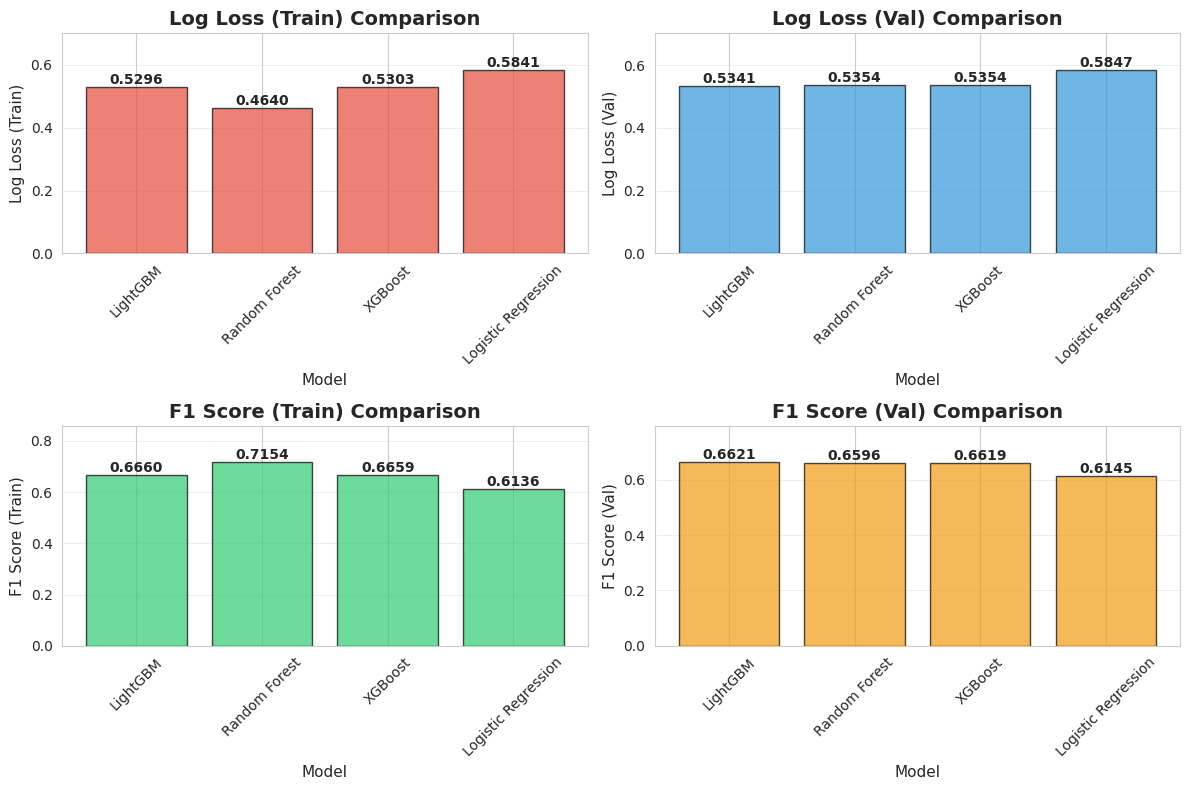

In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Log Loss (Val)')

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics = ['Log Loss (Train)', 'Log Loss (Val)', 'F1 Score (Train)', 'F1 Score (Val)']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]

    bars = ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black')
    ax.margins(y=0.2)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

`LightGBM` model showed best result on validation dataset.

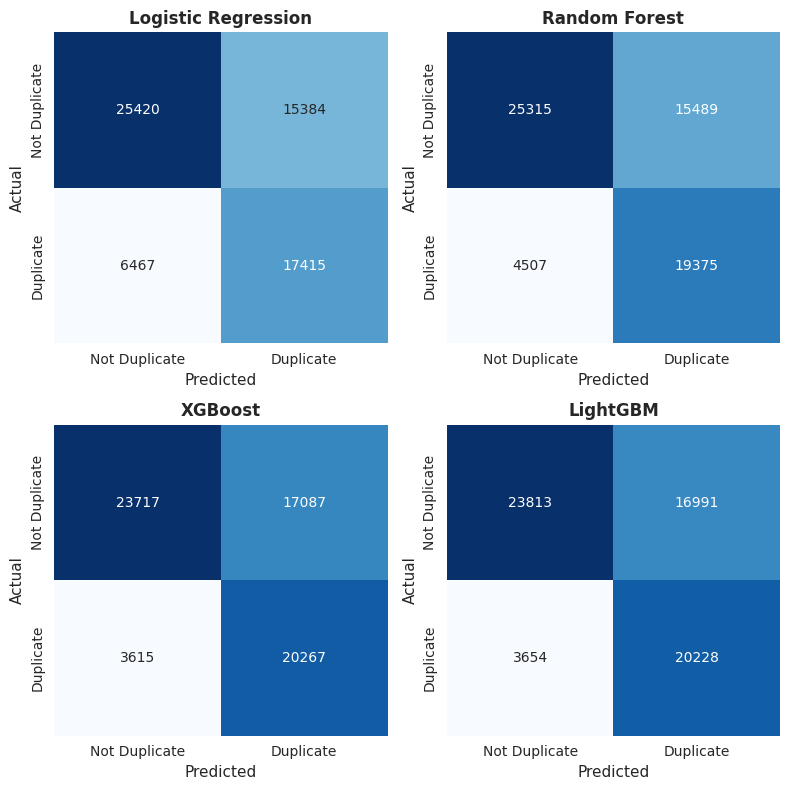

In [17]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = np.array(axes).flatten()

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]

    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_xticklabels(['Not Duplicate', 'Duplicate'])
    ax.set_yticklabels(['Not Duplicate', 'Duplicate'])

plt.tight_layout()
plt.show()

| Model              | Strengths                       | Weaknesses                             |
|--------------------|----------------------------------|------------------------------------------|
| Logistic Regression | Simple, robust baseline          | Misses many duplicates (high FN)         |
| Random Forest       | Better recall than LR            | Overpredicts duplicates (high FP)        |
| XGBoost             | Excellent recall and TP rate     | More false positives                     |
| LightGBM            | Best overall balance             | Slightly more FP than LR                |


## Feature Importance (XGBoost)

Top 10 Most Important Features:
               feature  importance
1   common_words_ratio    0.678674
0         common_words    0.068156
10          word_ratio    0.061222
8         unique_words    0.060051
9            word_diff    0.034899
7             q2_words    0.018935
5             q1_words    0.017961
2             len_diff    0.017505
4               q1_len    0.016324
3            len_ratio    0.013235


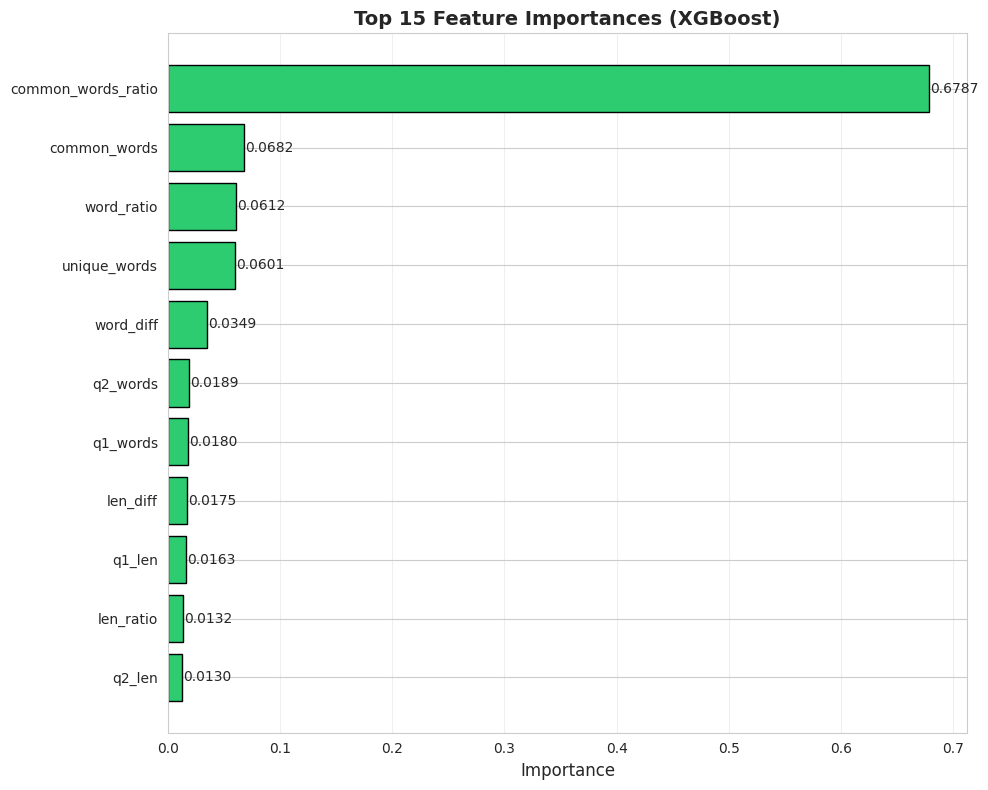

In [18]:
# Get feature importance from XGBoost
xgb_model = models['XGBoost']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)

bars = ax.barh(range(len(top_features)), top_features['importance'], color='#2ecc71', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## TF-IDF Features

In [19]:
all_questions_train = pd.concat([
    train_df['question1_clean'],
    train_df['question2_clean']
]).fillna('')

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_vectorizer.fit(all_questions_train)

# Compute TF-IDF matrices for train Q1 and Q2
q1_tfidf_train = tfidf_vectorizer.transform(train_df['question1_clean'].fillna(''))
q2_tfidf_train = tfidf_vectorizer.transform(train_df['question2_clean'].fillna(''))

# Cosine similarity for each pair (diagonal of similarity matrix)
tfidf_cosine_train = q1_tfidf_train.multiply(q2_tfidf_train).sum(axis=1).A1

train_df['tfidf_cosine'] = tfidf_cosine_train

print("TF-IDF cosine similarity for train added. Example values:")
print(train_df['tfidf_cosine'].head())

TF-IDF cosine similarity for train added. Example values:
qid1
317486    0.000000
198846    0.281668
350537    0.000000
87355     0.822883
253405    0.000000
Name: tfidf_cosine, dtype: float64


In [20]:
q1_tfidf_val = tfidf_vectorizer.transform(val_df['question1_clean'].fillna(''))
q2_tfidf_val = tfidf_vectorizer.transform(val_df['question2_clean'].fillna(''))
tfidf_cosine_val = q1_tfidf_val.multiply(q2_tfidf_val).sum(axis=1).A1
val_df['tfidf_cosine'] = tfidf_cosine_val

In [21]:
feature_cols_updated = feature_cols + ['tfidf_cosine']

X_train = train_df[feature_cols_updated]
X_val = val_df[feature_cols_updated]

X_train_num = csr_matrix(train_df[feature_cols_updated].values)
X_val_num   = csr_matrix(val_df[feature_cols_updated].values)

X_train_lr = hstack([q1_tfidf_train, q2_tfidf_train, X_train_num])
X_val_lr   = hstack([q1_tfidf_val,   q2_tfidf_val,   X_val_num])

In [22]:
lr_tfidf_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_tfidf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

xgb_tfidf_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric='logloss'
)

lgbm_tfidf_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=30,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    force_col_wise=True
)

In [23]:
tfidf_models = {
    "Logistic Regression TF-IDF": lr_tfidf_model,
    "Random Forest TF-IDF": rf_tfidf_model,
    "XGBoost TF-IDF": xgb_tfidf_model,
    "LightGBM TF-IDF": lgbm_tfidf_model
}

for name, model in tfidf_models.items():
    evaluate_model(
        name=name,
        model=model,
        X_train=X_train_lr,
        y_train=y_train,
        X_val=X_val_lr,
        y_val=y_val,
        models_dict=models,
        results_list=results
    )


*** Logistic Regression TF-IDF – TRAIN ***
Log Loss: 0.4688
F1 Score: 0.7201

*** Logistic Regression TF-IDF – VALIDATION ***
Log Loss: 0.4765
F1 Score: 0.7115

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.86      0.74      0.80     40804
    Duplicate       0.64      0.79      0.71     23882

     accuracy                           0.76     64686
    macro avg       0.75      0.77      0.75     64686
 weighted avg       0.78      0.76      0.77     64686


*** Random Forest TF-IDF – TRAIN ***
Log Loss: 0.5505
F1 Score: 0.6753

*** Random Forest TF-IDF – VALIDATION ***
Log Loss: 0.5553
F1 Score: 0.6682

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.86      0.63      0.72     40804
    Duplicate       0.56      0.82      0.67     23882

     accuracy                           0.70     64686
    macro avg       0.71      0.72      0.70     64686
 weighted 

## Model Comparison (TF-IDF)

In [24]:
model_comparison(results)

MODEL COMPARISON
                     Model  Log Loss (Train)  Log Loss (Val)  F1 Score (Train)  F1 Score (Val)
           LightGBM TF-IDF          0.456264        0.460964          0.723241        0.719197
Logistic Regression TF-IDF          0.468778        0.476519          0.720060        0.711487
            XGBoost TF-IDF          0.479419        0.484274          0.707529        0.704374
                  LightGBM          0.529574        0.534111          0.666016        0.662117
             Random Forest          0.464022        0.535383          0.715439        0.659619
                   XGBoost          0.530302        0.535423          0.665930        0.661931
      Random Forest TF-IDF          0.550548        0.555328          0.675340        0.668246
       Logistic Regression          0.584088        0.584665          0.613558        0.614492
Best Model: LightGBM TF-IDF
Best Log Loss: 0.4610


## Ensemble

In [25]:
lr_tfidf_ensemble_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

lgbm_tfidf_ensemble_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=30,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    force_col_wise=True
)

In [26]:
from sklearn.ensemble import VotingClassifier

voting_ensemble = VotingClassifier(
    estimators=[
        ("lr", lr_tfidf_ensemble_model),
        ("lgbm", lgbm_tfidf_ensemble_model),
    ],
    voting='soft',
    weights=[0.4, 0.6]
)

In [27]:
evaluate_model(
    name="Ensemble (LR & LGBM)",
    model=voting_ensemble,
    X_train=X_train_lr,
    y_train=y_train,
    X_val=X_val_lr,
    y_val=y_val,
    models_dict=models,
    results_list=results
)

[LightGBM] [Info] Number of positive: 95528, number of negative: 163215
[LightGBM] [Info] Total Bins 377213
[LightGBM] [Info] Number of data points in the train set: 258743, number of used features: 4012
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369200 -> initscore=-0.535649
[LightGBM] [Info] Start training from score -0.535649

*** Ensemble (LR & LGBM) – TRAIN ***
Log Loss: 0.4500
F1 Score: 0.7325

*** Ensemble (LR & LGBM) – VALIDATION ***
Log Loss: 0.4553
F1 Score: 0.7270

Validation Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.88      0.73      0.80     40804
    Duplicate       0.65      0.83      0.73     23882

     accuracy                           0.77     64686
    macro avg       0.76      0.78      0.76     64686
 weighted avg       0.79      0.77      0.77     64686



In [28]:
model_comparison(results)

MODEL COMPARISON
                     Model  Log Loss (Train)  Log Loss (Val)  F1 Score (Train)  F1 Score (Val)
      Ensemble (LR & LGBM)          0.449977        0.455301          0.732451        0.726993
           LightGBM TF-IDF          0.456264        0.460964          0.723241        0.719197
Logistic Regression TF-IDF          0.468778        0.476519          0.720060        0.711487
            XGBoost TF-IDF          0.479419        0.484274          0.707529        0.704374
                  LightGBM          0.529574        0.534111          0.666016        0.662117
             Random Forest          0.464022        0.535383          0.715439        0.659619
                   XGBoost          0.530302        0.535423          0.665930        0.661931
      Random Forest TF-IDF          0.550548        0.555328          0.675340        0.668246
       Logistic Regression          0.584088        0.584665          0.613558        0.614492
Best Model: Ensemble (LR & LGBM)


## Final Summary

In [29]:
print(f"\nModels Trained: {len(models)}")
print(f"  - {', '.join(models.keys())}")

print(f"\nBest Model: {best_model_name}")
print(f"\nValidation Performance:")
print(f"  - Log Loss: {best_logloss:.4f}")
print(f"  - F1 Score: {results_df.iloc[0]['F1 Score (Val)']:.4f}")


Models Trained: 9
  - Logistic Regression, Random Forest, XGBoost, LightGBM, Logistic Regression TF-IDF, Random Forest TF-IDF, XGBoost TF-IDF, LightGBM TF-IDF, Ensemble (LR & LGBM)

Best Model: Ensemble (LR & LGBM)

Validation Performance:
  - Log Loss: 0.4553
  - F1 Score: 0.6621


## Save Results

In [30]:
result_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates')
joblib.dump(results, result_dir / 'model_results.joblib')

['/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model_results.joblib']